In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from nanonets import Simulation
from matplotlib.colors import Normalize
from scipy.optimize import curve_fit
from scipy.special import gamma

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
U0_LIST     = np.linspace(0.01,0.05,CPU_CNT,endpoint=False)
N_VOLT      = 50000
TIME_STEP   = 1e-11
PLOT_NORM   = Normalize(vmin=U0_LIST[0], vmax=U0_LIST[-1])
CMAP        = plt.get_cmap('cividis')
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/"

def stretched_exp(t, tau, beta, I0):
    return I0*np.exp(-(t/tau)**beta)

In [173]:
topo    = {"Nx" : 1, "Ny" : 1, "electrode_type" : ['constant','constant']}
sim_c   = Simulation(topo)
tau_t   = 25*sim_c.get_capacitance_matrix()[0][0]*1e6*1e-9 # in ns
print(tau_t)

0.23628021769320412


In [174]:
t   = np.arange(N_VOLT) * TIME_STEP
y   = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Observable'].values for V in U0_LIST]).T
y   = np.vstack([np.zeros(len(U0_LIST)),y])
y_e = np.array([pd.read_csv(f"{FOLDER}set_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
y_e = np.vstack([np.zeros(len(U0_LIST)),y_e])
q   = np.array([pd.read_csv(f"{FOLDER}mean_state_set_{V:.5f}.csv")['Error'].values for V in U0_LIST]).T
q   = np.vstack([np.zeros(len(U0_LIST)),y_e])

FileNotFoundError: [Errno 2] No such file or directory: '/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/size_volt/set_0.01000.csv'

[0.8507989552648858, 0.16391804904392168, 0.2435050167903229, 0.2514493725741318, 0.33035351720583517, 0.16321959377521045, 0.35510618456490795, 0.20556071202218099, 0.18643548746324515, 0.17420246445606818]
[0.7615566740822021, 0.8364149525477504, 0.8477175269170619, 0.8660949067837477, 0.9048077102401537, 0.829508795279011, 0.9318716585175559, 0.8539124815794857, 0.9060802581787613, 0.8783578747066397]


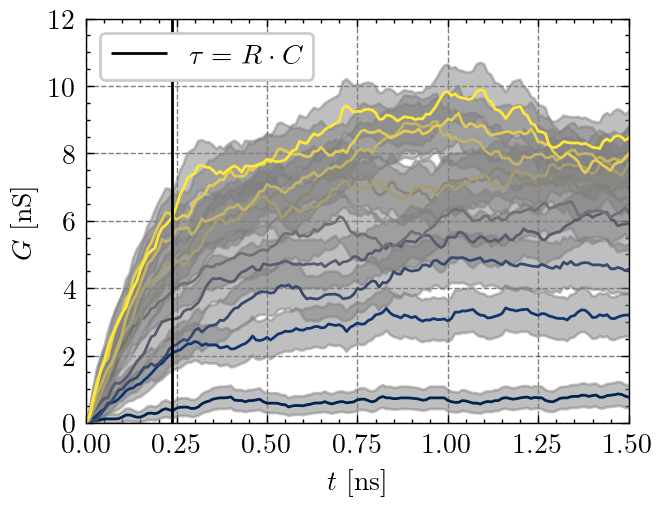

In [169]:
skip    = 0
min_con = 10
sat     = 1000
p_sat   = 0.95
fit_val = []
taus    = []
cvs     = []
fig, ax = plt.subplots(dpi=200)
for i, V in enumerate(V_VALUES[skip:]):

    # Plot Data
    t_copy  = t.copy()*1e9
    y_copy  = (y[:,i+skip].copy()*1e-9)/V
    ye_copy = (y_e[:,i+skip].copy()*1e-9)/V

    ax.plot(t_copy, y_copy, '-', color=CMAP(PLOT_NORM(V)))
    ax.fill_between(t_copy, y_copy-ye_copy, y_copy+ye_copy, color='grey', alpha=0.5)

    # Get Saturation Values and Transient Part
    sat_mean    = np.median(y_copy[-sat:])

    # threshold crossing: first index where y >= p_sat*sat_mean and persists for min_consec samples
    thresh  = p_sat * sat_mean
    above   = y_copy >= thresh
    # find first run of at least min_consec True
    idx_cut = None
    consec = 0
    for i, val in enumerate(above):
        if val:
            consec += 1
            if consec >= min_con:
                idx_cut = i - (min_con - 1) + 1
                break
        else:
            consec = 0

    # idx_cut     = int(np.where(y_copy>=(p_sat*sat_mean))[0][0])
    t_plot      = t_copy[:idx_cut]
    y_plot      = y_copy[:idx_cut]

    # Get Tau and CV (model-free)
    f       = (sat_mean - y_plot) / sat_mean
    norm    = np.trapz(f, x=t_plot)
    tau     = np.trapz(t_plot * f, x=t_plot) / norm
    tau2    = np.trapz(t_plot**2 * f, x=t_plot) / norm
    sigma   = np.sqrt(tau2 - tau**2)
    cv      = sigma / tau

    # Append
    taus.append(tau)
    cvs.append(cv)

_ = ax.vlines(tau_t, 0, 15, colors='black', label='$\\tau = R \cdot C$')
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$G$ [nS]")
_ = ax.set_xlim(0, 150*TIME_STEP*1e9)
_ = ax.set_ylim(0, 12)
_ = ax.legend()
print(taus)
print(cvs)

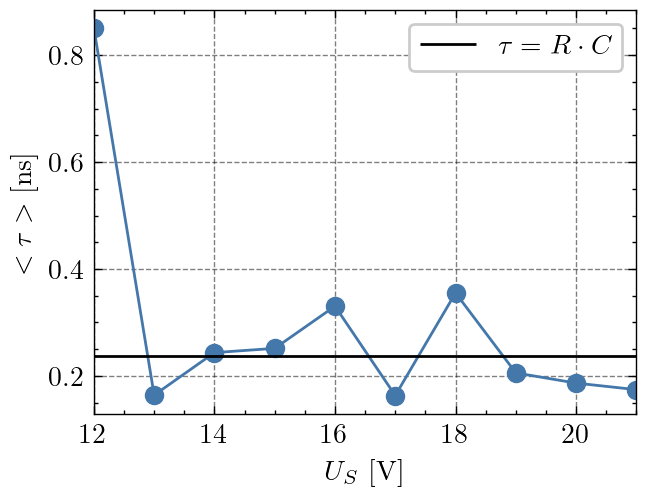

In [165]:
fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(V_VALUES[skip:])*1000, taus, '-o')#, label='$<\\tau> = \\frac{\\tau_K}{\\beta}\\Gamma(\\frac{1}{\\beta})$')
_ = ax.hlines(tau_t, V_VALUES[skip]*1000, V_VALUES[-1]*1000, colors='black', label='$\\tau = R \cdot C$')
_ = ax.legend()
_ = ax.set_xlabel("$U_S$ [V]")
_ = ax.set_ylabel("$<\\tau>$ [ns]")
_ = ax.set_xlim(V_VALUES[skip]*1000, V_VALUES[-1]*1000)

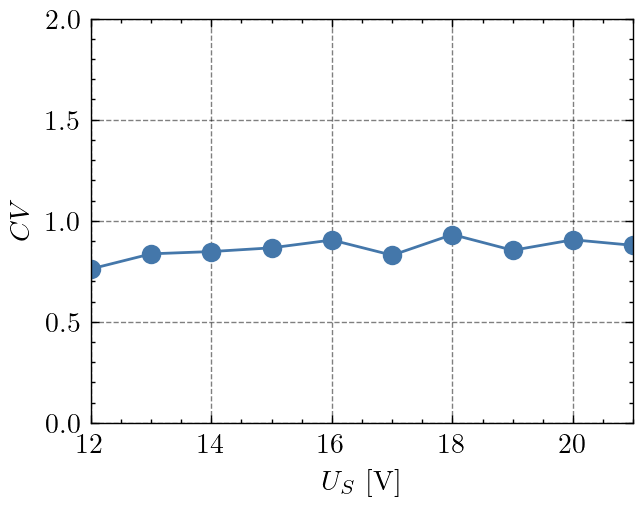

In [166]:
fig, ax = plt.subplots(dpi=200)
_ = ax.plot(np.array(V_VALUES[skip:])*1000, cvs, '-o')
_ = ax.set_xlabel("$U_S$ [V]")
_ = ax.set_ylabel("$CV$")
_ = ax.set_ylim(0,2)
_ = ax.set_xlim(V_VALUES[skip]*1000, V_VALUES[-1]*1000)